<a href="https://colab.research.google.com/github/DarioMameli/DL_Assignments/blob/main/DL_Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

Firstly let's import all the necessary packages and update them.

Also check the type of runtime environment.

In [1]:
!pip install keras --upgrade --quiet
!pip install keras-tuner --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 9.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.0.5 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.8 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras
from keras import regularizers
import matplotlib.gridspec as gridspec
from keras.datasets import fashion_mnist
from keras.layers import Dense, Flatten
from keras.models import Sequential
from keras.utils import to_categorical
import keras_tuner as kt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from dl_utils import plot_history

from sklearn.metrics import confusion_matrix, classification_report

In [3]:
print(tf.__version__)
print(keras.__version__)

2.15.0
3.0.5


In [4]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Load data

In [5]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
print(X_train.shape)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(60000, 28, 28)


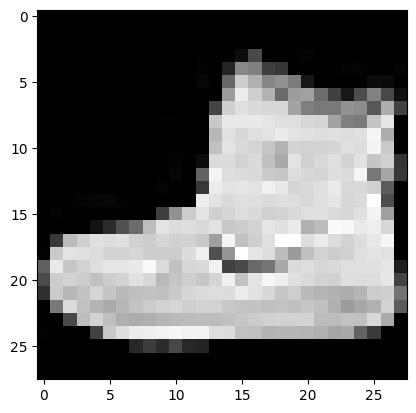

Label = 9


In [6]:
# Show an instance
plt.imshow(X_train[0], cmap="gray")


plt.show()
print("Label =", y_train[0])


In [7]:
# Input data preprocessing
print(np.min(X_train), np.max(X_train))
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

X_train /= 255
X_test /= 255

print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")

0 255
60000 train samples
10000 test samples


In [8]:
# Labels preprocessing
print(np.min(y_train), np.max(y_train))
num_classes = 10

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

print("First label is now = ", y_train[0])

0 9
First label is now =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


# Build the model
We use a simple fully connected network here using 8 hidden neurons, followed by another layer of 8 hidden neurons, and finally our output layer. We use the ReLU activation function, except for the output, where we apply a softmax activation as we're doing a multiclass classification here.


In [9]:
def MLPModel(num_classes):
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28)))
    model.add(Dense(8, activation="relu"))
    model.add(Dense(8, activation="relu"))
    model.add(Dense(num_classes, activation="softmax"))
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [10]:
model = MLPModel(num_classes)
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │           6,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │              90 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,442 (25.16 KB)

 Trainable params: 6,442 (25.16 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)
    print(layer.get_config())
    print()

0 flatten
{'name': 'flatten', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last'}

1 dense
{'name': 'dense', 'trainable': True, 'dtype': 'float32', 'units': 8, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}

2 dense_1
{'name': 'dense_1', 'trainable': True, 'dtype': 'float32', 'units': 8, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer

In [12]:
class MyMLPModel(kt.HyperModel):
  # Sets up the hyperparameters and calls the building model function
  def build(self, hp):
        model = self.build_MLP(hp)
        return model

  # Sets up the hyperparameters and calls the building model function
  def build_MLP(self, hp):
      # Tune the number of units for the Dense layers
      hp_units1 = hp.Int('units', min_value=32, max_value=512, step=32)
      hp_units2 = hp.Int('units', min_value=32, max_value=512, step=32)

      # Choose the activation function for the Dense layers
      hp_activation = hp.Choice("activation", ["relu", "tanh"])

      # Tune the learning rate for the optimizer
      hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

      # call existing model-building code with the hyperparameter values.
      model = self.build_MLP_hp(
          hp_units1=hp_units1, hp_units2=hp_units2, hp_activation=hp_activation,
          hp_learning_rate=hp_learning_rate
      )
      return model

  # Builds the actual model
  def build_MLP_hp(self, hp_units1, hp_units2, hp_activation, hp_learning_rate):
      model = Sequential()
      model.add(Flatten(input_shape=(28, 28)))
      model.add(Dense(units=hp_units1, activation=hp_activation))
      model.add(Dense(units=hp_units2, activation=hp_activation))
      model.add(Dense(10, activation="softmax"))
      model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                    loss="categorical_crossentropy", metrics=["accuracy"])
      return model

  def fit(self, hp, model, *args, **kwargs):
        # Initialize ImageDataGenerator for data augmentation
        datagen = ImageDataGenerator(
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest',
            validation_split=0.2
        )
        X_train = args[0]
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
        # Fit the data generator on the training data
        datagen.fit(X_train)
        # Tune the batch size
        hp_batch_size = hp.Choice('batch_size', values=[16, 32, 64, 128, 256])
        # Use the generator to augment the data during training
        return model.fit(
        datagen.flow(X_train, y_train, batch_size=hp_batch_size, shuffle=True, subset='training'),
        validation_data=datagen.flow(X_train, y_train, subset='validation'),  # Use original data for validation
        )

In [13]:
tuner = kt.Hyperband(MyMLPModel(),
                     objective='val_accuracy',
                     max_epochs=10,
                     #overwrite = True,
                     max_consecutive_failed_trials=5,
                     project_name='my_mlp_tuning',  # Specify a project name for organizing checkpoints
                     directory='my_mlp_tuning',     # Specify a directory for storing checkpoint files
)
tuner.search_space_summary()

Search space summary
Default search space size: 3
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


# Training


Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.4090 - loss: 1.6267 - val_accuracy: 0.7751 - val_loss: 0.6680
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.7806 - loss: 0.6271 - val_accuracy: 0.8053 - val_loss: 0.5655
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8083 - loss: 0.5503 - val_accuracy: 0.8113 - val_loss: 0.5502
Epoch 4/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8192 - loss: 0.5223 - val_accuracy: 0.8278 - val_loss: 0.5046
Epoch 5/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8299 - loss: 0.4895 - val_accuracy: 0.8288 - val_loss: 0.4923


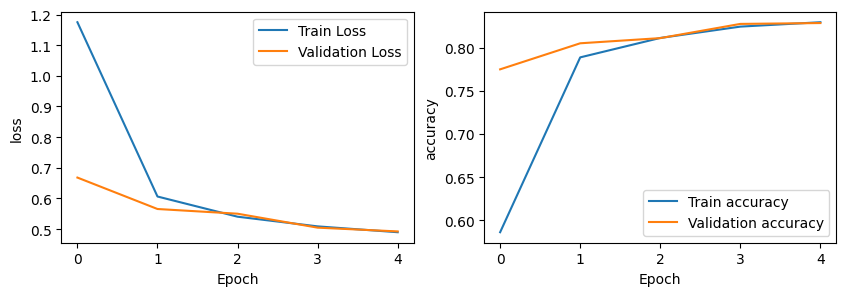

In [14]:
# Basic training

batch_size = 128
epochs = 5

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.2)
plot_history(history)

Trial 28 Complete [00h 00m 28s]
val_accuracy: 0.4152500033378601

Best val_accuracy So Far: 0.7292500138282776
Total elapsed time: 00h 12m 03s
Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7817 - loss: 0.6202 - val_accuracy: 0.8568 - val_loss: 0.3841
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8621 - loss: 0.3720 - val_accuracy: 0.8701 - val_loss: 0.3617
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8788 - loss: 0.3309 - val_accuracy: 0.8782 - val_loss: 0.3424
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8881 - loss: 0.3011 - val_accuracy: 0.8834 - val_loss: 0.3273
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8928 - loss: 0.2852 - val_accuracy: 0.8812 - val_loss: 0.3312
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8972 - loss: 0.2690 - val_accuracy: 0.8824 - val_loss: 0.3310
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9002 - lo

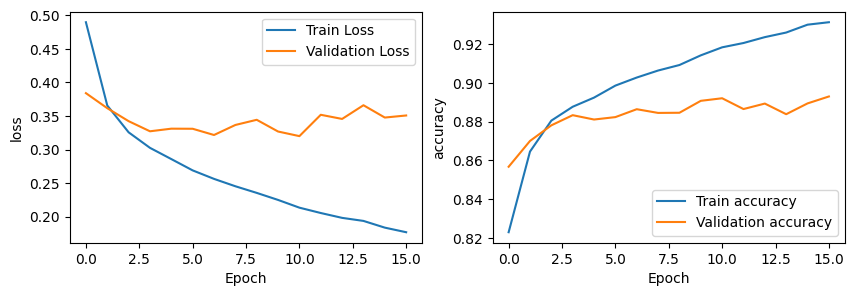

Best epoch: 16


In [15]:
# KerasTuner training

# Early stop to prevent overfitting
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(X_train, y_train, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters and train it on the data for 20 epochs
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, epochs=20, validation_split=0.2, callbacks=[stop_early])

plot_history(history)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [16]:
print(model.layers[1].get_weights()[0].shape)  # weights
print(model.layers[1].get_weights()[1].shape)  # bias

(784, 8)
(8,)


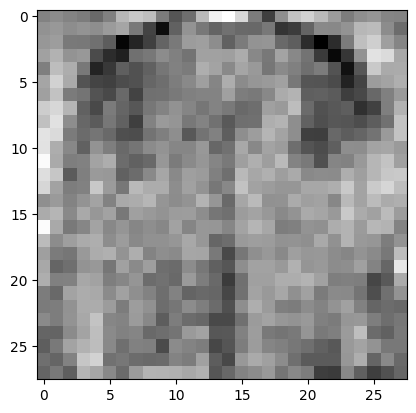

In [17]:
# Visualizing weights of first dense layer
rs = model.layers[1].get_weights()[0][:, 0].reshape(28, 28)
plt.imshow(rs, cmap="gray")
plt.show()

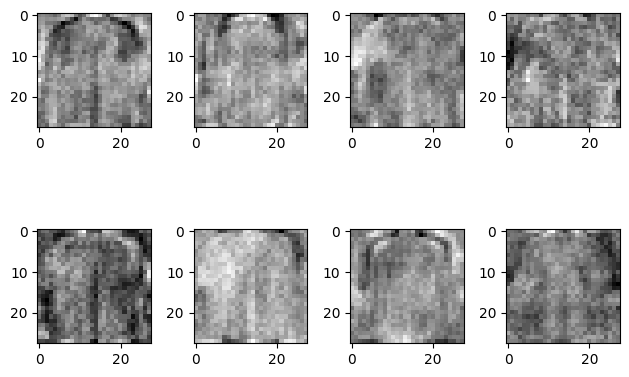

In [18]:
# Show all 8 weights of the first dense layer
gs = gridspec.GridSpec(2, 4)
for n in range(8):
    rs = model.layers[1].get_weights()[0][:, n].reshape(28, 28)
    ax = plt.subplot(gs[n])
    ax.imshow(rs, cmap="gray")
plt.tight_layout()
plt.show()

# Evaluation

In [19]:
score = model.evaluate(X_test, y_test, verbose=0)

print("Basic model")
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Basic model
Test loss: 0.5084344148635864
Test accuracy: 0.8259999752044678


In [20]:
score = best_model.evaluate(X_test, y_test, verbose=0)

print("Keras Tuner model")
print("Best parameters:", best_hps.values)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Keras Tuner model
Best parameters: {'units': 256, 'activation': 'relu', 'learning_rate': 0.001, 'batch_size': 32, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 2, 'tuner/round': 0}
Test loss: 0.37876373529434204
Test accuracy: 0.8877999782562256


In [21]:
scores = model.predict(np.array([X_train[0]]))

print(scores)
print("Predicted label = ", np.argmax(scores))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
[[1.5934561e-11 1.9413314e-17 1.5325719e-12 1.4869718e-10 1.0870185e-14
  2.2185463e-03 7.4315337e-12 1.0194092e-02 3.7531088e-05 9.8754984e-01]]
Predicted label =  9


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


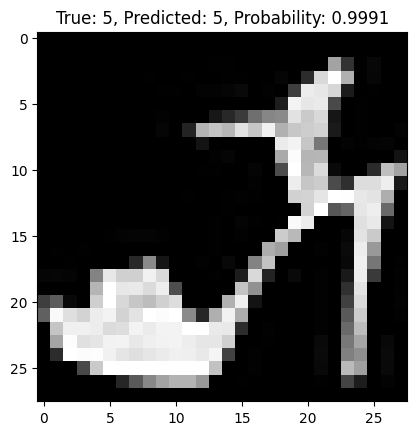

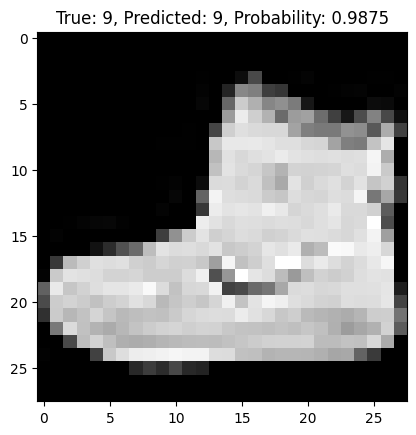

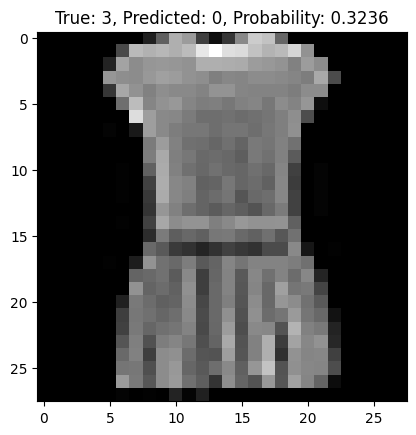

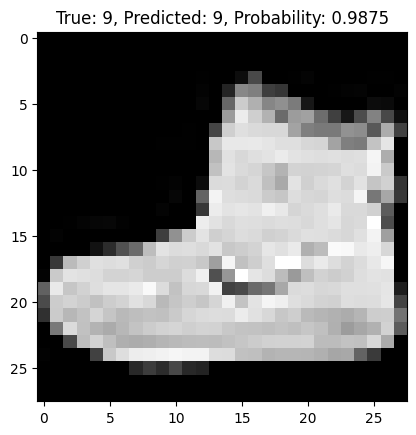

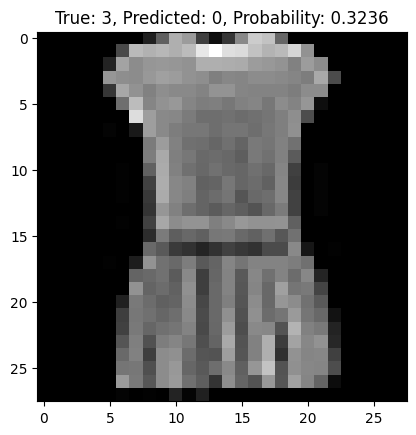

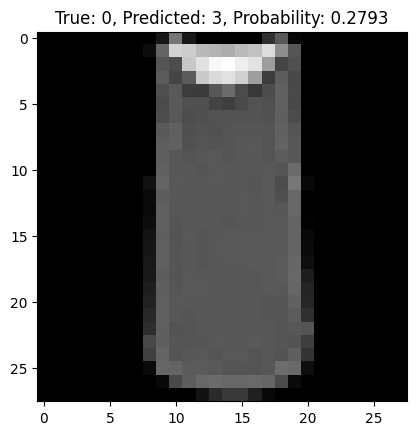

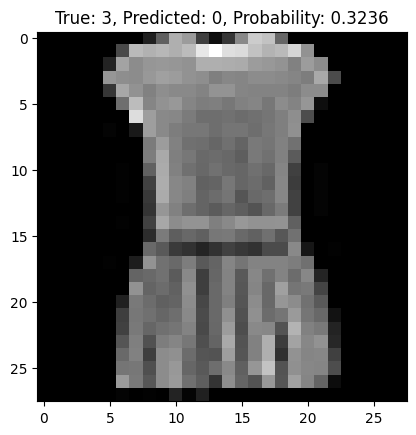

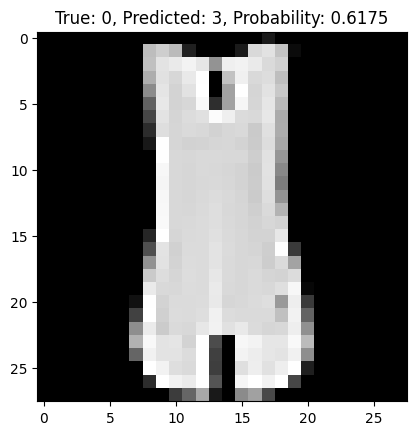

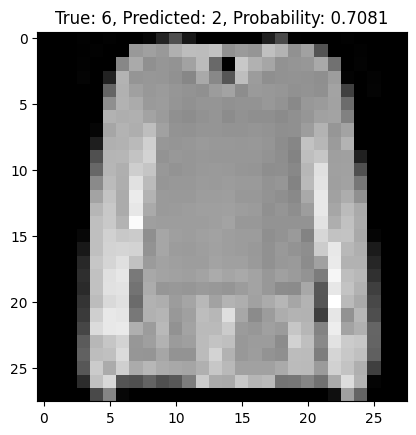

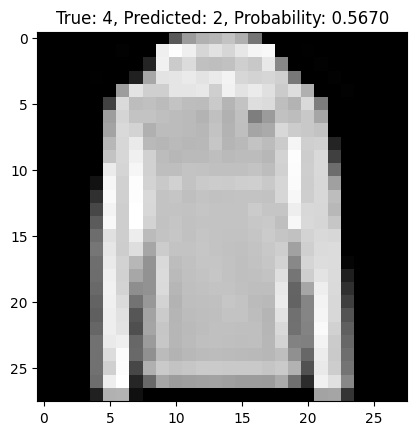

              precision    recall  f1-score   support

           0       0.81      0.79      0.80      6000
           1       0.98      0.94      0.96      6000
           2       0.70      0.73      0.72      6000
           3       0.82      0.89      0.85      6000
           4       0.72      0.75      0.74      6000
           5       0.92      0.93      0.93      6000
           6       0.62      0.57      0.59      6000
           7       0.93      0.88      0.91      6000
           8       0.95      0.94      0.94      6000
           9       0.91      0.95      0.93      6000

    accuracy                           0.84     60000
   macro avg       0.84      0.84      0.84     60000
weighted avg       0.84      0.84      0.84     60000



In [22]:
y_pred_probs = model.predict(X_train)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

y_true = np.argmax(y_train, axis=1)

most_convinced_indices = np.argmax(y_pred_probs, axis=1)
most_confused_indices = np.where(y_true != y_pred_labels)[0]

for index in most_convinced_indices[:5]:
    plt.imshow(X_train[index],cmap="gray")
    plt.title(f'True: {y_true[index]}, Predicted: {y_pred_labels[index]}, Probability: {y_pred_probs[index, y_pred_labels[index]]:.4f}')
    plt.show()

for index in most_confused_indices[:5]:
    plt.imshow(X_train[index],cmap="gray")
    plt.title(f'True: {y_true[index]}, Predicted: {y_pred_labels[index]}, Probability: {y_pred_probs[index, y_pred_labels[index]]:.4f}')
    plt.show()

print(classification_report(y_true, y_pred_labels))


The model exhibits weaknesses in accurately predicting clothing items, while demonstrating strengths in classifying various types of shoes. There is an opportunity for improvement by focusing on enhancing the model's performance in the classification of clothing items.